In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('telecom_churn.csv')

In [27]:
df.sample(5)

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,InternetService,MonthlyCharges,TotalCharges,Churn,Timestamp
24477,CUST024478,Female,0.0,NaN,No,12.0,No,NaN,41.50,NaN,No,NaN
34196,CUST034197,NaN,0.0,No,Yes,5.0,NaN,NaN,63.53,335.92,No,NaN
58406,CUST058407,Female,1.0,No,No,9.0,Yes,Fiber optic,NaN,327.57,No,2020-04-13
40069,CUST040070,Male,0.0,Yes,Yes,NaN,Yes,DSL,118.58,1269.24,No,NaN
26820,CUST026821,Male,0.0,No,NaN,4.0,Yes,Fiber optic,28.04,70.68,No,2020-05-27


In [28]:
df.shape

(100000, 12)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerID       100000 non-null  object 
 1   Gender           81787 non-null   object 
 2   SeniorCitizen    81861 non-null   float64
 3   Partner          81994 non-null   object 
 4   Dependents       82003 non-null   object 
 5   Tenure           82001 non-null   float64
 6   PhoneService     82096 non-null   object 
 7   InternetService  81579 non-null   object 
 8   MonthlyCharges   81904 non-null   float64
 9   TotalCharges     80257 non-null   object 
 10  Churn            100000 non-null  object 
 11  Timestamp        81757 non-null   object 
dtypes: float64(3), object(9)
memory usage: 9.2+ MB


In [30]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerID       100000 non-null  object 
 1   Gender           81787 non-null   object 
 2   SeniorCitizen    81861 non-null   float64
 3   Partner          81994 non-null   object 
 4   Dependents       82003 non-null   object 
 5   Tenure           82001 non-null   float64
 6   PhoneService     82096 non-null   object 
 7   InternetService  81579 non-null   object 
 8   MonthlyCharges   81904 non-null   float64
 9   TotalCharges     79409 non-null   float64
 10  Churn            100000 non-null  object 
 11  Timestamp        81757 non-null   object 
dtypes: float64(4), object(8)
memory usage: 9.2+ MB


In [32]:
df.isnull().sum()

CustomerID             0
Gender             18213
SeniorCitizen      18139
Partner            18006
Dependents         17997
Tenure             17999
PhoneService       17904
InternetService    18421
MonthlyCharges     18096
TotalCharges       20591
Churn                  0
Timestamp          18243
dtype: int64

In [33]:
df.drop(columns=['CustomerID','Timestamp'],inplace=True)

<Axes: xlabel='MonthlyCharges', ylabel='Density'>

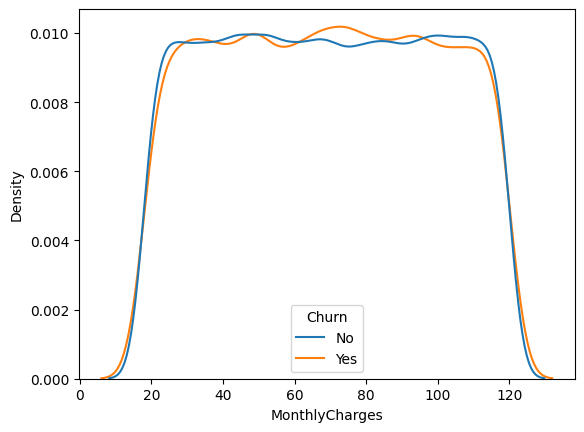

In [34]:
import seaborn as sns
sns.kdeplot(data=df, x='MonthlyCharges', hue='Churn', common_norm=False)

<Axes: >

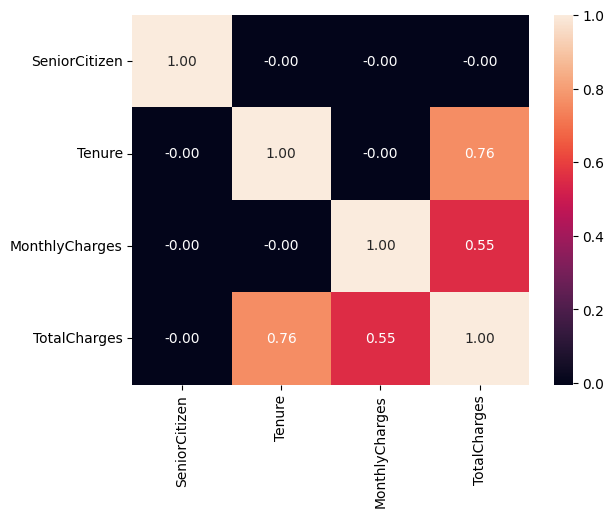

In [35]:
numeric_cols=df.select_dtypes(include=['number']).columns
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt='.2f')

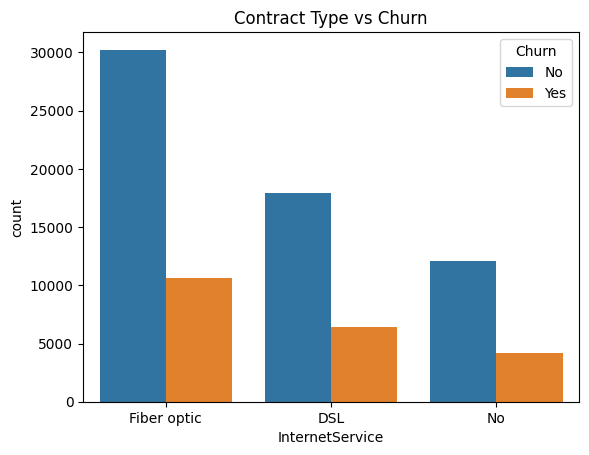

In [36]:

sns.countplot(data=df, x="InternetService", hue="Churn")
plt.title("Contract Type vs Churn")
plt.show()


# Key Findings from EDA  

1. **Dataset Size:**  
   - 100,000 rows and 12 columns.  

2. **Irrelevant Features:**  
   - Dropped `CustomerID` and `Timestamp` since they do not contribute to prediction.  

3. **Missing Values:**  
   - Present in most columns (except `CustomerID` and `Churn`).  
   - Will be handled in the preprocessing pipeline.  

4. **Data Type Fix:**  
   - Converted `TotalCharges` from object → numeric.  

5. **Correlation Analysis:**  
   - `Tenure` and `TotalCharges` are strongly correlated (**0.76**).  
   - `MonthlyCharges` and `TotalCharges` show moderate correlation (**0.55**).  
   - `SeniorCitizen` has very weak correlation with other numeric variables.  

6. **Churn vs Internet Service:**  
   - Customers with **Fiber optic internet** show the highest churn.  

7. **Monthly Charges Distribution:**  
   - Customers who churn generally have **higher monthly charges** compared to those who stay.  


In [37]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

df["AvgChargesPerMonth"] = df["TotalCharges"] / (df["Tenure"] + 1)

df["TenureCategory"] = pd.cut(
    df["Tenure"],
    bins=[0, 12, 36, df["Tenure"].max()],
    labels=["New", "Mid", "Loyal"],
    right=True
)


In [38]:
df.columns

Index(['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'PhoneService', 'InternetService', 'MonthlyCharges', 'TotalCharges',
       'Churn', 'AvgChargesPerMonth', 'TenureCategory'],
      dtype='object')

In [39]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [40]:
X = df.drop("Churn", axis=1)
y = df["Churn"].map({"Yes": 1, "No": 0})

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [42]:
num_features = ["Tenure", "MonthlyCharges", "TotalCharges","SeniorCitizen"]

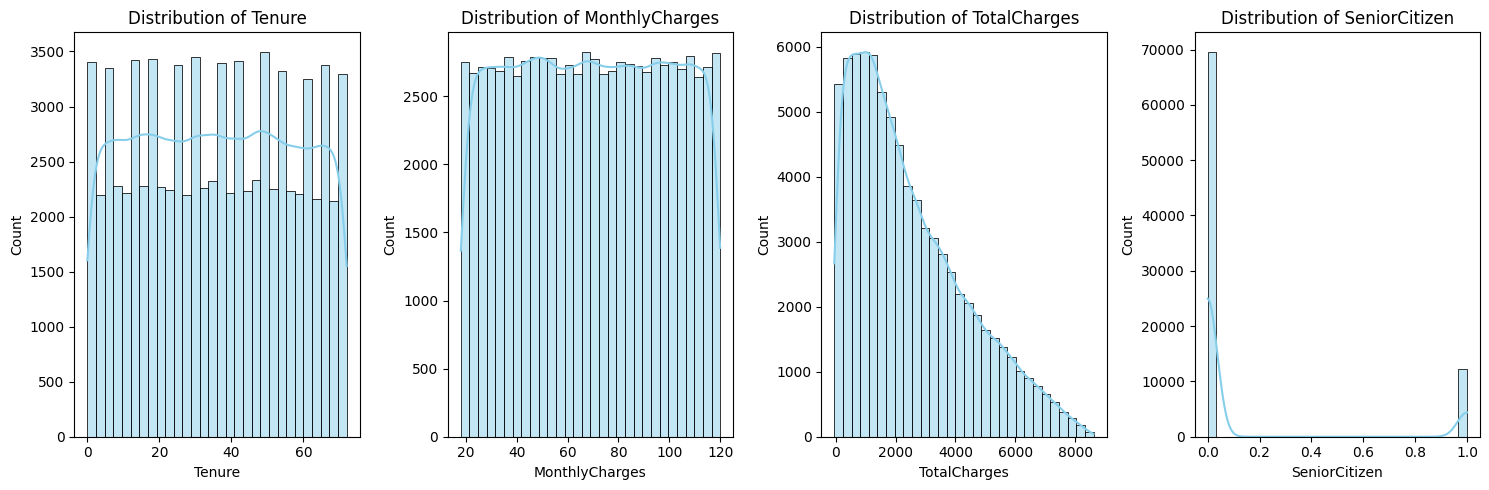

In [43]:
plt.figure(figsize=(15, 5))

for i, col in enumerate(num_features, 1):
    plt.subplot(1, len(num_features), i)
    sns.histplot(df[col], bins=30, kde=True, color="skyblue")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [44]:
for i in num_features:
    print(df[i].skew())

0.007688614049534383
0.00034615084197719135
0.8417541157253984
1.9673082406133762


In [45]:
#Numerical Features
mean_features = ["Tenure", "MonthlyCharges"]
median_features = ["TotalCharges"]
mode_features = ["SeniorCitizen"] 

num_mean_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

num_median_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

num_mode_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent"))
])

In [47]:
#Categorical Features
cat_features = ["Gender", "Partner", "Dependents", "PhoneService", "InternetService"]
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])


In [48]:
preprocessor = ColumnTransformer(transformers=[
    ("num_mean", num_mean_transformer, mean_features),
    ("num_median", num_median_transformer, median_features),
    ("num_mode", num_mode_transformer, mode_features),
    ("cat", cat_transformer, cat_features)
])
preprocessor

,transformers,"[('num_mean', ...), ('num_median', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'mean'
,fill_value,None


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import GridSearchCV

pipeline_lr = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42))
])

param_grid_lr = {
    "classifier__C": [0.01, 0.1, 1, 10],
    "classifier__penalty": ["l2"]
}

grid_lr = GridSearchCV(
    pipeline_lr,
    param_grid=param_grid_lr,
    cv=5,
    scoring="f1_weighted",
    n_jobs=-1,
    verbose=1
)

grid_lr.fit(X_train, y_train)
print("Logistic Regression Best Params:", grid_lr.best_params_)
print("Best F1-Weighted:", grid_lr.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Logistic Regression Best Params: {'classifier__C': 0.01, 'classifier__penalty': 'l2'}
Best F1-Weighted: 0.5110174246178044


In [ ]:
pipeline_rf = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__max_depth": [5, 10, 20],
    "classifier__min_samples_split": [2, 5]
}

grid_rf = GridSearchCV(
    pipeline_rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring="f1_weighted",
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)
print("Random Forest Best Params:", grid_rf.best_params_)
print("Best F1-Weighted:", grid_rf.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Random Forest Best Params: {'classifier__max_depth': 20, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 300}
Best F1-Weighted: 0.6028991309076472


In [51]:
pipeline_gb = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", GradientBoostingClassifier(random_state=42))
])

param_grid_gb = {
    "classifier__n_estimators": [100, 200],
    "classifier__learning_rate": [0.01, 0.1, 0.2],
    "classifier__max_depth": [3, 5]
}

grid_gb = GridSearchCV(
    pipeline_gb,
    param_grid=param_grid_gb,
    cv=5,
    scoring="f1_weighted",
    n_jobs=-1,
    verbose=1
)

grid_gb.fit(X_train, y_train)
print("Gradient Boosting Best Params:", grid_gb.best_params_)
print("Best F1-Weighted:", grid_gb.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\Dell\OneDrive\Desktop\DAU\ML\Assignments\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Gradient Boosting Best Params: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 5, 'classifier__n_estimators': 100}
Best F1-Weighted: 0.6388860026611753


In [52]:
best_model = grid_rf

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

print("\n--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred))

print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.74      0.68      0.71     14791
           1       0.27      0.32      0.29      5209

    accuracy                           0.59     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.62      0.59      0.60     20000


--- Confusion Matrix ---
[[10124  4667]
 [ 3524  1685]]

ROC AUC Score: 0.502760592624808


# Interpretation

[[10124  4667]   → Actual 0 (No Churn)
 [ 3524  1685]]  → Actual 1 (Churn)


True Negatives (TN = 10124): Correctly predicted non-churners.

False Positives (FP = 4667): Predicted churn, but actually stayed.

False Negatives (FN = 3524): Predicted stay, but actually churned.

True Positives (TP = 1685): Correctly predicted churner

**Business Cost:**

**False Positives (FP)**: You incorrectly assume a loyal customer will churn.

    Cost: unnecessary retention offers (discounts, promos, calls).

**False Negatives (FN)**: You fail to identify a churner.

    Cost: lost revenue, lost customer lifetime value, and potentially higher acquisition cost to replace them.

**Which is worse?**
    
    False Negatives are far worse because missing actual churners means you lose customers permanently.

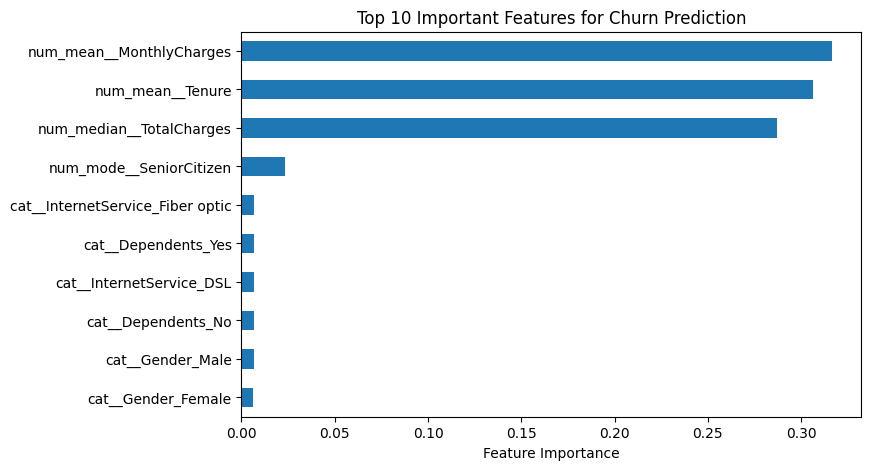

In [53]:
import matplotlib.pyplot as plt
import pandas as pd

feature_names = grid_rf.best_estimator_.named_steps["preprocessor"].get_feature_names_out()

importances = grid_rf.best_estimator_.named_steps["classifier"].feature_importances_

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(10)

plt.figure(figsize=(8,5))
feat_imp.plot(kind="barh")
plt.title("Top 10 Important Features for Churn Prediction")
plt.xlabel("Feature Importance")
plt.gca().invert_yaxis()
plt.show()


# Likely Top Features in datasets

Tenure → Shorter tenure = higher churn risk.

MonthlyCharges → Higher monthly bills often lead to churn.

TotalCharges → Related to tenure & monthly cost, indicates customer value.

InternetService (Fiber Optic) → Fiber customers often have higher churn due to cost.

SeniorCitizen → Older customers sometimes have different churn behavior.

Partner / Dependents → Customers with family ties churn less.

PhoneService → Add-on services affect loyalty.

Contract Type (if included in full dataset) → Month-to-month contracts usually churn more.

Payment Method (if included) → Electronic check users often churn more.

Gender → Usually weak, but still present.